#### Calculations:  Returns, Covariance, and Correlation
- Created: 2020.08.07
- Last Edited: 2021.01.18

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import date, datetime

import matplotlib.pyplot as plt
%matplotlib inline

##### Functions

In [2]:
# Function to compute an asset's expected return
def expected_return(historical_returns):
    """
    Function computes an asset's expected return
    """
    T = (~historical_returns.isna()).count() # number of observations
    return np.round(((1/T) * np.sum(historical_returns)) * 100, 4)

In [3]:
# Function to compute an asset's variance (or volatility)
def var_return(historical_returns, expected_return):
    """
    Function computes an asset's variance
    """
    T = (~historical_returns.isna()).count() # number of observations
    return np.round((1/(T-1)) * np.sum((historical_returns - expected_return)**2) * 100, 4)

##### Import Equity Data

In [4]:
equity_data = pd.read_excel("../Output/Equity_Data_2021-01-18.xlsx", index_col="Date")
equity_data.head()

,SPY,AAPL,INTC
Date,,,
2007-03-01,140.509995,3.109286,19.590000
2007-03-02,138.669998,3.050357,19.219999
2007-03-05,137.350006,3.082857,19.110001
2007-03-06,139.699997,3.149643,19.400000
2007-03-07,139.559998,3.132857,19.120001


##### Compute Daily Returns (Two Ways)

In [5]:
# pre-processing: fill any 'NA' values with the prior non-NA value
equity_data.fillna(method='ffill', inplace=True)

In [6]:
# Daily returns: log returns
log_returns_matrix = pd.DataFrame(index=equity_data.index)
for ticker in equity_data.columns:
    log_returns_matrix[ticker] = np.log(equity_data[ticker].shift(1) / equity_data[ticker])

log_returns_matrix.dropna(axis=0, inplace=True) # drop na values
log_returns_matrix.index = [datetime.strptime(dt, '%Y-%M-%d').date() 
                            for dt in log_returns_matrix.index]
log_returns_matrix.head()

,SPY,AAPL,INTC
2007-01-02,0.013182,0.019134,0.019068
2007-01-05,0.009565,-0.010598,0.005740
2007-01-06,-0.016965,-0.021432,-0.015061
2007-01-07,0.001003,0.005344,0.014538
2007-01-08,-0.008420,-0.003187,-0.005737


In [7]:
# Daily returns: percent change
pct_chg_returns_matrix = pd.DataFrame(index=equity_data.index)
for ticker in equity_data.columns:
    pct_chg_returns_matrix[ticker] = equity_data[ticker].pct_change()

pct_chg_returns_matrix.dropna(axis=0, inplace=True) # drop na values
pct_chg_returns_matrix.index = [datetime.strptime(dt, '%Y-%M-%d').date() 
                                for dt in pct_chg_returns_matrix.index]
pct_chg_returns_matrix.head()

,SPY,AAPL,INTC
2007-01-02,-0.013095,-0.018953,-0.018887
2007-01-05,-0.009519,0.010654,-0.005723
2007-01-06,0.017110,0.021664,0.015175
2007-01-07,-0.001002,-0.005329,-0.014433
2007-01-08,0.008455,0.003192,0.005753


##### Compute the Covariance Matrix of Daily Returns

In [8]:
def covariance_returns(returns_i, expected_return_i, returns_j, expected_return_j):
    """
    Function build the covariance matrix of returns
    Inputs:
    returns_i: returns of asset i
    expected_return_i: the expected return of asset i
    returns_j: returns of asset j
    expected_return_j: the expected return of asset j
    """
    T = (~returns_i.isna()).count()
    return np.round(((1/(T-1)) * np.sum((returns_i - expected_return_i) * (returns_j - expected_return_j))) * 100, 4)

In [9]:
# compute pre-requisite calculations: asset expected returns and variances
expected_returns = np.array([expected_return(log_returns_matrix[ticker]) for ticker in log_returns_matrix.columns])
variance_returns = np.array([var_return(log_returns_matrix[ticker], expected_returns[i]) for (i,ticker) in enumerate(log_returns_matrix.columns)])

In [10]:
# compute the covariance matrix using daily log returns
n = len(log_returns_matrix.columns) # number of assets
cov_matrix = np.zeros(n**2).reshape(n,n) # covariance matrix has size n x n

for i in range(1, n):
    for j in range(1, n):
        if i == j:
            cov_matrix[i,j] = var_return(log_returns_matrix.iloc[:,i], expected_returns[i-1])
        else:
            cov_matrix[i,j] = covariance_returns(log_returns_matrix.iloc[:,i], expected_returns[i-1],
                                                 log_returns_matrix.iloc[:,j], expected_returns[j-1])

cov_matrix = pd.DataFrame(cov_matrix, index=log_returns_matrix.columns, columns=log_returns_matrix.columns)
cov_matrix.style.background_gradient(cmap='coolwarm')

,SPY,AAPL,INTC
SPY,0.000000,0.000000,0.000000
AAPL,0.000000,0.097600,0.249000
INTC,0.000000,0.249000,0.941300


##### Compute the Correlation Matrix of Daily Returns

In [11]:
# compute correlation coefficient
def correlation_matrix(covariance, std_i, std_j, i, j):
    """
    Function builds the correlation matrix of returns
    Inputs:
    covariance: the covariance between assets i and j
    std_i: the standard deviation of asset i
    std_j: the standard deviation of asset j
    i: the index of asset i
    j: the index of asset j
    """
    if i == j:
        return 1
    else:
        return covariance / (std_i * std_j)

In [12]:
# compute the correlation matrix using daily log returns
cor_matrix = np.zeros(n**2).reshape(n,n) # covariance matrix has size n x n

for i in range(0, n):
    for j in range(0, n):
        cov_returns = cov_matrix.iloc[i,j]
        std_dev_i = np.sqrt(variance_returns[i-1])
        std_dev_j = np.sqrt(variance_returns[j-1])
        cor_matrix[i,j] = correlation_matrix(cov_returns, std_dev_i, std_dev_j, i, j)

cor_matrix = pd.DataFrame(cor_matrix, index=log_returns_matrix.columns, columns=log_returns_matrix.columns)
cor_matrix.style.background_gradient(cmap='coolwarm')

,SPY,AAPL,INTC
SPY,1.000000,0.000000,0.000000
AAPL,0.000000,1.000000,0.926297
INTC,0.000000,0.926297,1.000000


##### Exploratory Data Analysis

In [13]:
# quick descriptive attributes of the daily log returns data set
log_returns_matrix.describe()

,SPY,AAPL,INTC
count,3210.000000,3210.000000,3210.000000
mean,-0.000252,-0.000956,-0.000341
std,0.012249,0.019694,0.018322
min,-0.135577,-0.130194,-0.111988
25%,-0.005568,-0.011039,-0.009548
50%,-0.000582,-0.001002,-0.000624
75%,0.003965,0.007799,0.008740
max,0.103637,0.197470,0.132210


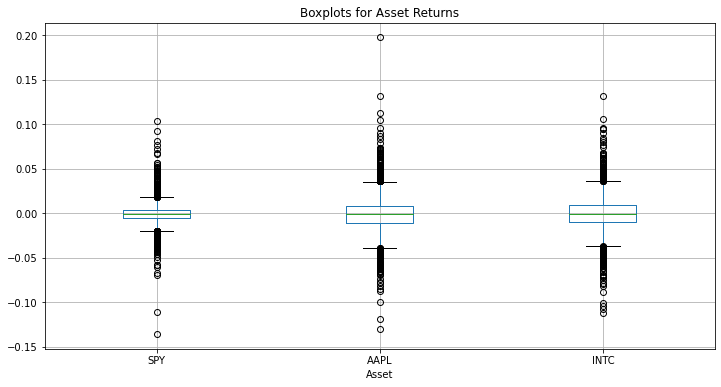

In [14]:
# box plot illustrating the range of each asset's returns
log_returns_matrix.boxplot(figsize=(12,6))
plt.title("Boxplots for Asset Returns")
plt.xlabel("Asset")
plt.show()

##### Visualization of Market Returns over Time (using SPY as proxy)

In [15]:
# compute 20-day and 50-day rolling averages
mkt_twenty_day_rolling_avg = log_returns_matrix["SPY"].rolling(window=20).mean()
mkt_fifty_day_rolling_avg = log_returns_matrix["SPY"].rolling(window=50).mean()

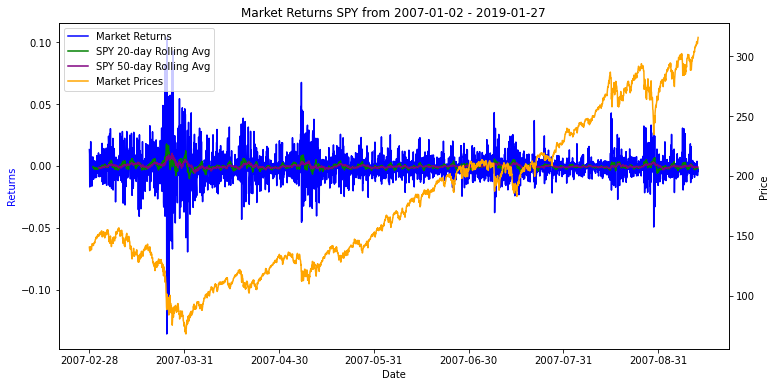

In [17]:
# plot market returns and historical prices
x = log_returns_matrix.index
y1 = log_returns_matrix["SPY"].values
y2 = mkt_twenty_day_rolling_avg.values
y3 = mkt_fifty_day_rolling_avg.values
y4 = equity_data["SPY"].values

start_date = x[0]
end_date = x[-1]

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xticklabels(pd.date_range(start_date, end_date, freq='M').date)
plt.title('Market Returns SPY from {} - {}'.format(start_date, end_date))

ax1.set_xlabel('Date'); ax1.set_ylabel('Returns', color='blue')
line1 = ax1.plot(y1, color='blue', label='Market Returns')
line2 = ax1.plot(y2, color='green', label='SPY 20-day Rolling Avg')
line3 = ax1.plot(y3, color='purple', label='SPY 50-day Rolling Avg')

ax2 = ax1.twinx(); ax2.set_ylabel('Price');
line4 = ax2.plot(y4, color="orange", label="Market Prices")

handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handle1+handle2, label1+label2, loc='upper left')

plt.savefig('../Output/Market_Returns_SPY_{}_{}_{}.png'.format(start_date, end_date, date.today()))
plt.show()

##### Export Output

In [18]:
# export to excel
with pd.ExcelWriter("../Output/Returns_Covariance_Correlation_{}.xlsx".format(date.today())) as output:
    equity_data.to_excel(output, sheet_name="Equity_Data")
    log_returns_matrix.to_excel(output, sheet_name="Daily_Log_Returns_Matrix")
    cov_matrix.style.background_gradient(cmap='coolwarm').to_excel(output, sheet_name="Covariance_Matrix")
    cor_matrix.style.background_gradient(cmap='coolwarm').to_excel(output, sheet_name="Correlation_Matrix")